# Some Difficulties in SVM Training

If you try searching for ways to train SVMs without using solvers or existing packages you may end up in the same position as me. The math behind SVMs can be expressed fairly simply, optimization is a different ball game.

$min_{w,b} \frac{1}{2}w^Tw + C\sum^{N}_{i}{\xi_i}$ 

$st. \: y_i(w^Tx_i + b) \geq 1 - \xi_i$

The below implementation gives this problem to a quadratic programming solver. 

In [1]:
using JuMP, COSMO, MLJ, LinearAlgebra, Plots

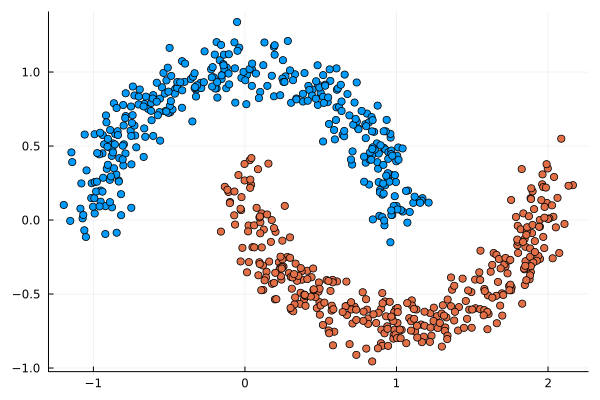

In [32]:
X, Y = make_moons(700, as_table = false)
n, m = size(X)
Y = 2 .* Y .- 1
scatter(X[:, 1], X[:, 2], group = Y, legend = false)

------------------------------------------------------------------
          COSMO v0.8.6 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{703},
          constraints: A ∈ R^{1400x703} (3500 nnz),
          matrix size to factor: 2103x2103,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 1400
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 1.02ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
1	-9.1680e

775	 1.2606e+02	3.6864e-03	1.9128e-04	1.0000e-01
800	 1.2606e+02	3.3966e-03	9.3502e-05	1.0000e-01
825	 1.2606e+02	7.1464e-03	9.6393e-03	8.0892e-01
850	 1.2607e+02	8.2758e-03	1.0018e-02	8.0892e-01
875	 1.2607e+02	4.8652e-03	1.0916e-02	8.0892e-01
900	 1.2606e+02	3.3122e-03	1.8839e-02	8.0892e-01
925	 1.2606e+02	3.3260e-03	4.2650e-03	8.0892e-01
950	 1.2607e+02	3.0058e-03	1.1979e-02	8.0892e-01
975	 1.2607e+02	1.6776e-03	2.6550e-03	8.0892e-01
1000	 1.2607e+02	1.6741e-03	3.2077e-03	8.0892e-01
1025	 1.2607e+02	3.9537e-04	5.3180e-03	8.0892e-01
1050	 1.2607e+02	2.2338e-04	1.1374e-03	8.0892e-01
1075	 1.2607e+02	1.6070e-04	2.9939e-03	8.0892e-01
1100	 1.2607e+02	3.1189e-04	4.8759e-04	1.4860e-01
1125	 1.2607e+02	1.8858e-04	1.3715e-04	1.4860e-01


1150	 1.2607e+02	1.1893e-04	2.8813e-04	1.4860e-01
1175	 1.2607e+02	2.4046e-05	9.2612e-05	1.4860e-01
1200	 1.2607e+02	2.1287e-05	3.2889e-05	1.4860e-01

------------------------------------------------------------------
>>> Results
Status: Solved
Iterations: 1240 (incl. 40 safeguarding iter)
Optimal objective: 126.1
Runtime: 0.217s (217.0ms)



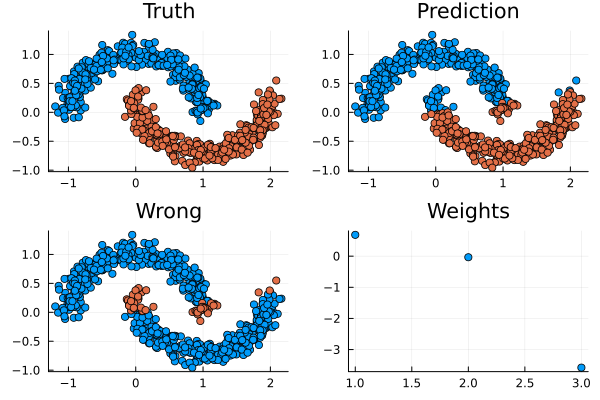

In [44]:
model = JuMP.Model(COSMO.Optimizer)
C = 1
@variable(model, w[1:m])
@variable(model, b)
@variable(model, ξ[1:n] >= 0)
for i in 1:n
    @constraint(model, Y[i] * (w' * X[i, :] + b) >= 1 - ξ[i])
end
@objective(model, Min, 1/2 * w' * w + C*sum(ξ))
JuMP.optimize!(model)
l = @layout [a p; n w]
p1 = scatter(X[:, 1], X[:, 2], group = Y, legend = false, title = "Truth")
p2 = scatter(X[:, 1], X[:, 2], group = sign.(X * value.(w) .+ value.(b)), legend = false, title = "Prediction")
wrong = sign.(X * value.(w) .+ value.(b)) .!= Y
p3 = scatter(X[:, 1], X[:, 2], group = wrong, legend = false, title = "Wrong")
p4 = scatter(1:(m + 1), [value.(w); value(b)] |> sort |> reverse, title = "Weights")
plot(p1, p2, p3, p4, layout = l, legend = false)


Nice and simple, as long as you aren't the one implementing the solver. I'm embarrassed to say it took me days to figure out how to write 10 lines of code. I actually didn't figure out this "simpler" solution before the Pegasos algorithm, mostly because I was dead set on not using external libraries. The program for the dual takes less lines of code for the actual model, visualization takes more. Always a trade off right?

------------------------------------------------------------------
          COSMO v0.8.6 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{700},
          constraints: A ∈ R^{1401x700} (2100 nnz),
          matrix size to factor: 2101x2101,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 1400
          ZeroSet of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 104.29ms

Iter:	Objective:	Primal 

50	-3.5826e+00	1.4214e-02	1.5724e-02	1.7026e+00
75	-3.6433e+00	4.3470e-03	6.0093e-03	1.7026e+00
100	-4.3088e+00	6.7232e-05	3.3529e-04	1.4330e+01


125	-4.3101e+00	6.8591e-10	1.2051e-07	1.4330e+01

------------------------------------------------------------------
>>> Results
Status: Solved
Iterations: 125
Optimal objective: -4.31
Runtime: 0.321s (321.0ms)



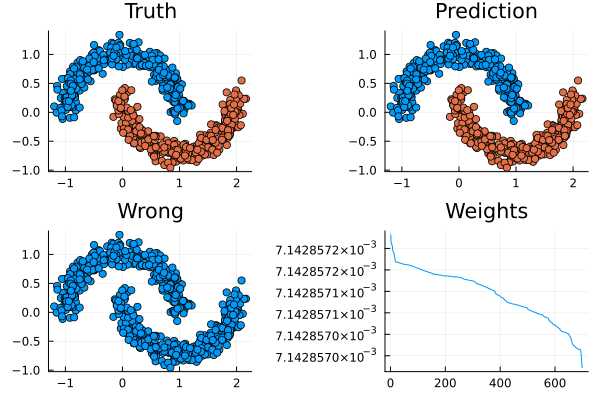

In [64]:
lam = .1
ρ(x, y) = exp(-norm(x - y)^2 / .1)
model = JuMP.Model(COSMO.Optimizer)
@variable(model, 0 <= α[1:n] <= 1/(2 * n * lam))
@constraint(model, sum(α[i] * Y[i] for i in 1:n) == 0)
@objective(model, Max, -1/2 * sum(Y[i] * α[i] * ρ(X[i], X[j]) * Y[j] * α[j] for i in 1:n, j in 1:n) + sum(α[i] for i in 1:n))
optimize!(model)
A = value.(α)
k(x) = y -> ρ(x, y)
predict(v) = sum(αi * yi * ki for (αi, yi, ki) in zip(A, Y, k(v).(X |> eachrow .|> collect)))
P = sign.(predict.(X |> eachrow))
l = @layout [a p; n w]
p1 = scatter(X[:, 1], X[:, 2], group = Y, legend = false, title = "Truth")
p2 = scatter(X[:, 1], X[:, 2], group = P, legend = false, title = "Prediction")
wrong = P .!= Y
p3 = scatter(X[:, 1], X[:, 2], group = wrong, legend = false, title = "Wrong")
p4 = plot(value.(α) |> sort |> reverse, title = "Weights")
plot(p1, p2, p3, p4, layout = l, legend = false)

I don't know 